# **Keras CNN Dog or Cat Classification**

https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification

## 1. Import Library

In [4]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## 2. Define Constants

In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## 3.Prepare Training Data

In [6]:
filenames = os.listdir("/content/drive/MyDrive/dataset/dog_train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,cat.460.jpg,0
1,cat.463.jpg,0
2,cat.469.jpg,0
3,cat.468.jpg,0
4,cat.47.jpg,0


In [8]:
df.tail()

,filename,category
1397,cat.456.jpg,0
1398,cat.448.jpg,0
1399,cat.453.jpg,0
1400,cat.455.jpg,0
1401,cat.471.jpg,0


* See Total in count

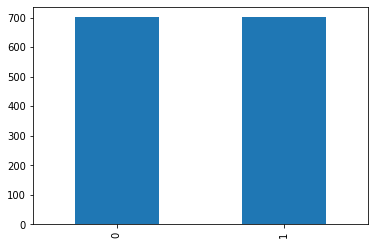

In [9]:
df['category'].value_counts().plot.bar()

###4. See sample image

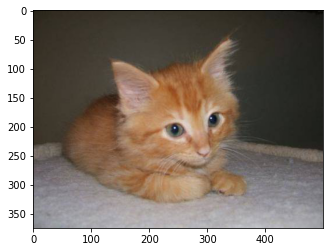

In [10]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/dataset/dog_train/"+sample)
plt.imshow(image)

## 5. Build Model

* input layer :It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* Conv Layer :  This layer will extract features from image.
* Polling Layer : This layerreduce the spatial volume of input image after convolution.
* Fully Connected Layer : It connect the network from a layer to another layer
* Output Layer : It is the predicted values layer.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## 6. Collbacks

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

* Early Stop

In [13]:
earlystop = EarlyStopping(patience=10)

* Learning Rate Reduction

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

## 7. Prepare data

* convert 1 to dog and 0 to cat

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

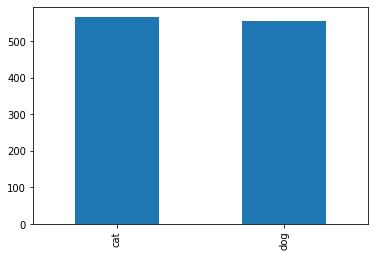

In [18]:
train_df['category'].value_counts().plot.bar()

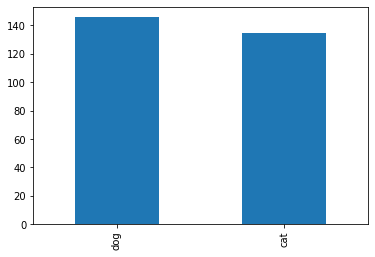

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## 8. Training Generator

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/dataset/dog_train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


* Validation Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/dataset/dog_train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


## 9. See how our generator work

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/dataset/dog_train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


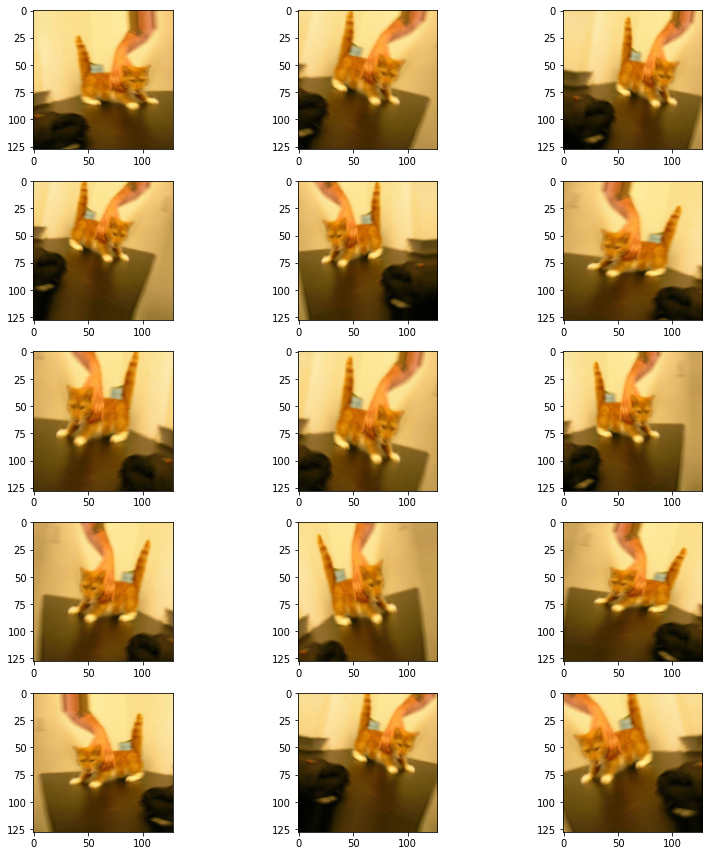

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 9. Fit Model

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-25-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.2942 - accuracy: 0.5723

74/74 [==============================] - 67s 878ms/step - loss: 1.2942 - accuracy: 0.5723 - val_loss: 6.2370 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0487 - accuracy: 0.5850

74/74 [==============================] - 65s 879ms/step - loss: 1.0487 - accuracy: 0.5850 - val_loss: 3.8869 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.6157

74/74 [==============================] - 63s 850ms/step - loss: 0.8746 - accuracy: 0.6157 - val_loss: 1.2708 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.6058

74/74 [==============================] - 63s 853ms/step - loss: 0.8286 - accuracy: 0.6058 - val_loss: 0.8526 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.6266

74/74 [==============================] - 65s 881ms/step - loss: 0.7435 - accuracy: 0.6266 - val_loss: 0.6770 - val_accuracy: 0.6148 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.6320

74/74 [==============================] - 63s 852ms/step - loss: 0.7151 - accuracy: 0.6320 - val_loss: 0.6348 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.6582

74/74 [==============================] - 63s 847ms/step - loss: 0.6596 - accuracy: 0.6582 - val_loss: 0.7167 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.6899

74/74 [==============================] - 62s 842ms/step - loss: 0.5975 - accuracy: 0.6899 - val_loss: 0.8066 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.7071

74/74 [==============================] - 65s 871ms/step - loss: 0.5789 - accuracy: 0.7071 - val_loss: 0.9205 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7152

74/74 [==============================] - 63s 844ms/step - loss: 0.5762 - accuracy: 0.7152 - val_loss: 0.6197 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.7107

74/74 [==============================] - 63s 850ms/step - loss: 0.5731 - accuracy: 0.7107 - val_loss: 0.7306 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7215

74/74 [==============================] - 63s 854ms/step - loss: 0.5812 - accuracy: 0.7215 - val_loss: 0.5615 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7206

74/74 [==============================] - 66s 890ms/step - loss: 0.5553 - accuracy: 0.7206 - val_loss: 0.5812 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7288

74/74 [==============================] - 64s 861ms/step - loss: 0.5605 - accuracy: 0.7288 - val_loss: 0.6462 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.7432

74/74 [==============================] - 64s 860ms/step - loss: 0.5492 - accuracy: 0.7432 - val_loss: 0.6789 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.7170

74/74 [==============================] - 65s 882ms/step - loss: 0.5578 - accuracy: 0.7170 - val_loss: 0.6008 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.7414

74/74 [==============================] - 63s 856ms/step - loss: 0.5187 - accuracy: 0.7414 - val_loss: 0.5956 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7523

74/74 [==============================] - 63s 854ms/step - loss: 0.5254 - accuracy: 0.7523 - val_loss: 0.7200 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.7532

74/74 [==============================] - 65s 878ms/step - loss: 0.5069 - accuracy: 0.7532 - val_loss: 0.5405 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.7450

74/74 [==============================] - 63s 854ms/step - loss: 0.5224 - accuracy: 0.7450 - val_loss: 0.6475 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7514

74/74 [==============================] - 63s 849ms/step - loss: 0.5131 - accuracy: 0.7514 - val_loss: 0.6205 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7514

74/74 [==============================] - 65s 878ms/step - loss: 0.4928 - accuracy: 0.7514 - val_loss: 0.6667 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.7830

74/74 [==============================] - 63s 853ms/step - loss: 0.4855 - accuracy: 0.7830 - val_loss: 0.4977 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 24/50
74/74 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7830

74/74 [==============================] - 63s 855ms/step - loss: 0.4714 - accuracy: 0.7830 - val_loss: 0.8548 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 25/50
74/74 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7803

74/74 [==============================] - 64s 862ms/step - loss: 0.5004 - accuracy: 0.7803 - val_loss: 0.5321 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 26/50
74/74 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.7685

74/74 [==============================] - 65s 884ms/step - loss: 0.4798 - accuracy: 0.7685 - val_loss: 0.6946 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 27/50
74/74 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.7893

74/74 [==============================] - 63s 854ms/step - loss: 0.4661 - accuracy: 0.7893 - val_loss: 0.8383 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 28/50
74/74 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8119

74/74 [==============================] - 64s 857ms/step - loss: 0.4448 - accuracy: 0.8119 - val_loss: 0.6477 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 29/50
74/74 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8038

74/74 [==============================] - 66s 886ms/step - loss: 0.4297 - accuracy: 0.8038 - val_loss: 1.1561 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 30/50
74/74 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8047

74/74 [==============================] - 63s 856ms/step - loss: 0.4500 - accuracy: 0.8047 - val_loss: 0.5166 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 31/50
74/74 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.7975

74/74 [==============================] - 64s 867ms/step - loss: 0.4585 - accuracy: 0.7975 - val_loss: 0.5304 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 32/50
74/74 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.7948

74/74 [==============================] - 65s 870ms/step - loss: 0.4496 - accuracy: 0.7948 - val_loss: 0.5811 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 33/50
74/74 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8020

74/74 [==============================] - 67s 898ms/step - loss: 0.4428 - accuracy: 0.8020 - val_loss: 0.5318 - val_accuracy: 0.7481 - lr: 0.0010


## 10. Save Model

In [26]:
model.save_weights("model.h5")

## 11. Virtualize Training 

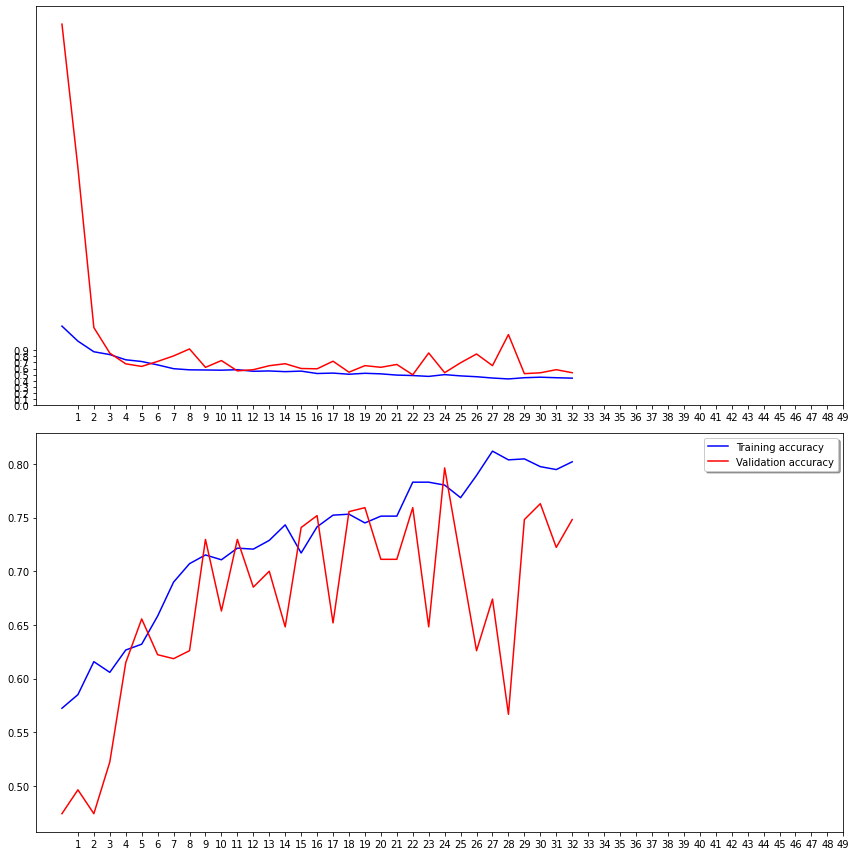

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## 12. Prepare Testing Data

In [28]:
test_filenames = os.listdir("/content/drive/MyDrive/dataset/dog_test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## 13. Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/dataset/dog_test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


## 14. Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-30-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

* convert predict category back into our generator classes by using train_generator.class.indices

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

* Virtualize Result

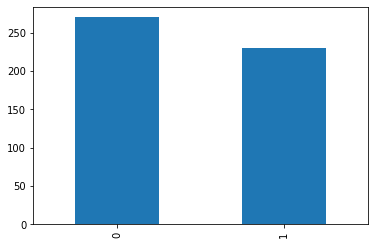

In [34]:
test_df['category'].value_counts().plot.bar()

* See predicted result wigh images

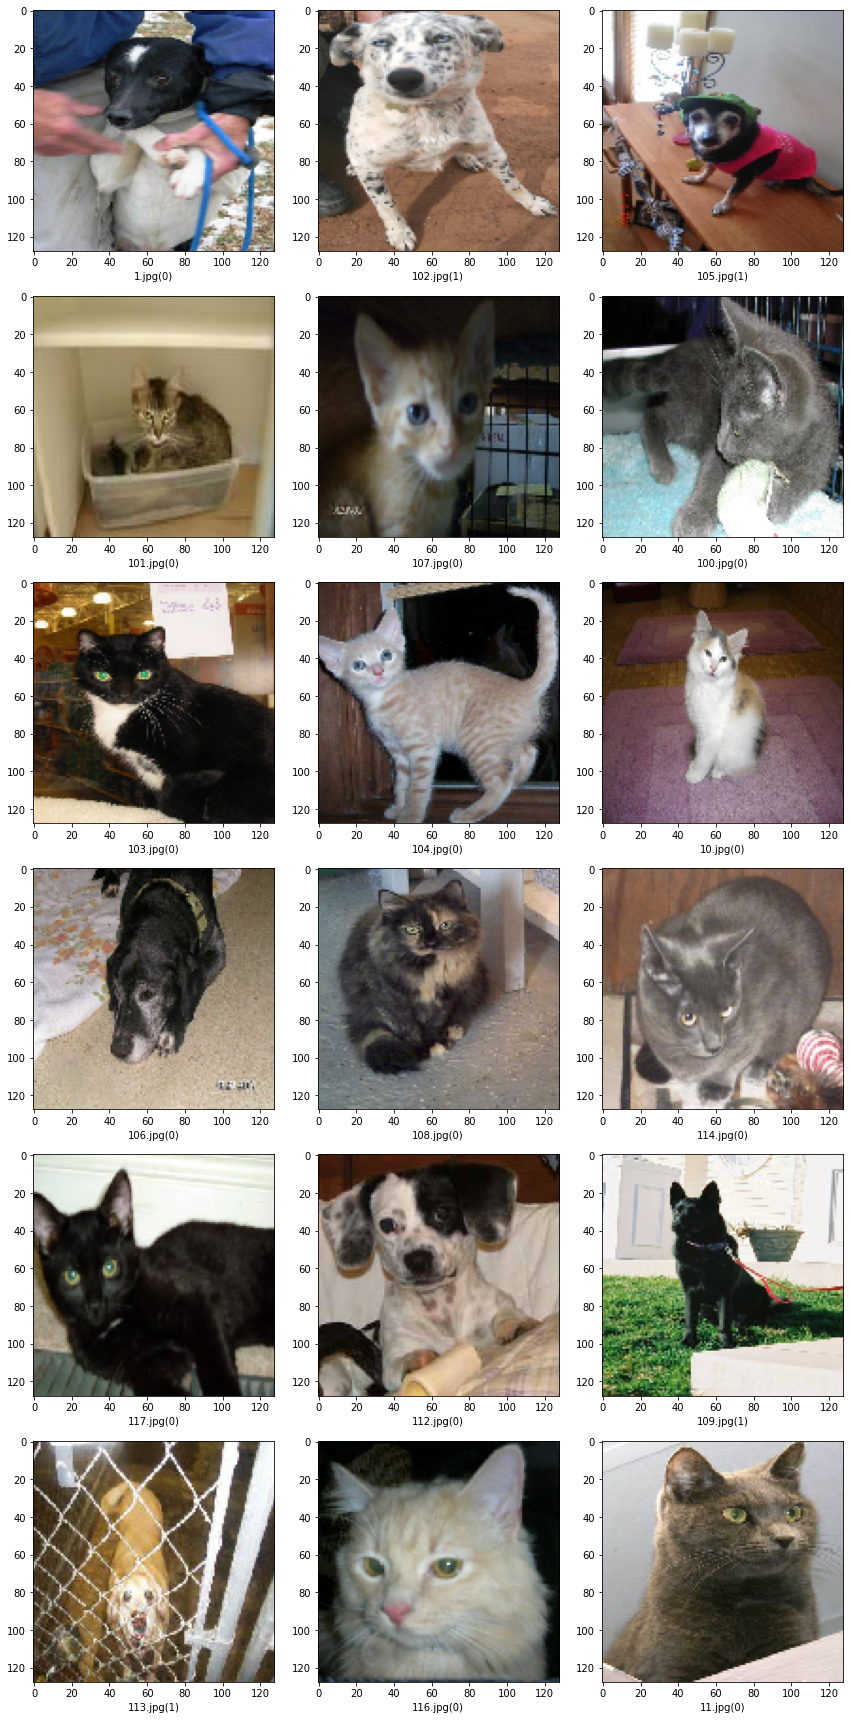

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/dataset/dog_test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## 15. Submission

In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)